# Tarea 2 - Introducción a las Redes Neuronales y Deep Learning

**Nombre:** Bruno Morici

**ROL USM:** 202373555-8

**Curso:** INF395, Introducción a las Redes Neuronales y Deep Learning

**Profesor:** Alejandro Veloz

**Fecha:** 21/10/2025

# Parte I: Desbalance de clases

### Pasos:
- Se hará uso de un dataset de clasificación de imágenes
- Artificialmente se limitarán las muestras de una clase para generar un desbalance artificial
- Se creará y entrenará un modelo FANN con las muestras totales
- Luego se harán predicciones midiendo el Acuraccy y el F1-Score (sobre todo en la clase desbalanceada, donde se espera sea cercano a cero)
- Luego se aplicará el método de Data Augmentation, para tomar las pocas muestras de la clase desbalanceada y balancearla a la par de las otras
- Finalmente se reentrenará el modelo, realizando nuevas predicciones y mediciones, para ver el efecto del método de rebalanceamiento.

In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report
from collections import Counter

In [47]:
# Carga del dataset, creamos conjuntos de entrenamiento y prueba
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalización de los datos
train_images = train_images / 255.0
test_images = test_images / 255.0

# Definimos los nombres de las clases
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



In [48]:
minority_class = 4  # Desbalanceamos la clase "Coat"

minority_idx = np.where(train_labels == minority_class)[0]
majority_idx = np.where(train_labels != minority_class)[0]

np.random.seed(42)
minority_idx_reduced = np.random.choice(minority_idx, 100, replace=False)

new_train_idx = np.concatenate([minority_idx_reduced, majority_idx])
train_images_ds = train_images[new_train_idx] # Nuevo dataset de entrenamiento desbalanceado
train_labels_ds = train_labels[new_train_idx] # Nuevas etiquetas de entrenamiento desbalanceadas

print("Cantidad de imágenes desbalanceadas por clase:")
for i in range(10):
    print(f"{class_names[i]}: {(train_labels_ds==i).sum()}")



Cantidad de imágenes desbalanceadas por clase:
T-shirt/top: 6000
Trouser: 6000
Pullover: 6000
Dress: 6000
Coat: 100
Sandal: 6000
Shirt: 6000
Sneaker: 6000
Bag: 6000
Ankle boot: 6000


In [49]:
# Creamos el modelo de arquitectura estándar con capas de neuronas mediante Keras
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

### 1.1 - Modelo desbalanceado
Modelo con solo 100 muestras de la clase "Coat"

In [50]:
# Fiteamos el modelo con el dataset desbalanceado
model_ds = create_model()
model_ds.fit(train_images_ds, train_labels_ds, epochs=10, verbose=2)

# Evaluamos el modelo desbalanceado
prob_model_ds = tf.keras.Sequential([model_ds, tf.keras.layers.Softmax()])
predictions_ds = np.argmax(prob_model_ds.predict(test_images), axis=1)

# Métricas para la clase desbalanceada "Coat"
mask = test_labels == minority_class
acc_ds = accuracy_score(test_labels[mask], predictions_ds[mask])
f1_ds = f1_score(test_labels[mask], predictions_ds[mask], average='macro')

# Resultados
print(f"Desbalanceado - Accuracy Coat: {acc_ds:.4f}, F1 Coat: {f1_ds:.4f}")


c:\Users\Bruno\Desktop\INF395 - IRN\tareas\tarea_2\tf_venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1691/1691 - 5s - 3ms/step - accuracy: 0.8585 - loss: 0.4212
Epoch 2/10
1691/1691 - 4s - 2ms/step - accuracy: 0.8920 - loss: 0.3049
Epoch 3/10
1691/1691 - 4s - 2ms/step - accuracy: 0.9017 - loss: 0.2722
Epoch 4/10
1691/1691 - 5s - 3ms/step - accuracy: 0.9090 - loss: 0.2488
Epoch 5/10
1691/1691 - 4s - 2ms/step - accuracy: 0.9144 - loss: 0.2329
Epoch 6/10
1691/1691 - 4s - 3ms/step - accuracy: 0.9186 - loss: 0.2188
Epoch 7/10
1691/1691 - 5s - 3ms/step - accuracy: 0.9222 - loss: 0.2073
Epoch 8/10
1691/1691 - 4s - 3ms/step - accuracy: 0.9257 - loss: 0.1992
Epoch 9/10
1691/1691 - 5s - 3ms/step - accuracy: 0.9300 - loss: 0.1886
Epoch 10/10
1691/1691 - 4s - 2ms/step - accuracy: 0.9316 - loss: 0.1814
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Desbalanceado - Accuracy Coat: 0.0950, F1 Coat: 0.0347


Ejemplo de predicción para el Modelo Desbalanceado

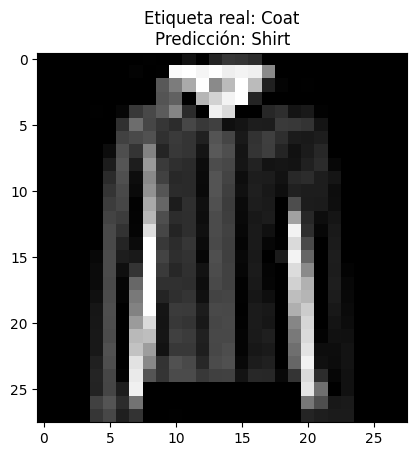

In [51]:
idx = np.where(test_labels==minority_class)[0][0]
plt.imshow(test_images[idx], cmap='gray')
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[predictions_ds[idx]]}")
plt.show()

### 1.2 - Balanceo Artificial por remuestreo
- Modelo generado mediante un balanceo artificial de la clase "Coat"
- Se generaron rotaciones y modificaciones de altura y largo para modificar las muestras existentes y generar más.
- Se utiliza la técnica de remuestreo, mas puntualmente la de oversampling.

Balanceo por técnica de remuestreo oversampling

In [52]:
# Aumentación de datos para balancear la clase minoritaria
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)

# Extraemos las imágenes y etiquetas de la clase minoritaria
minority_imgs = train_images_ds[train_labels_ds==minority_class]
minority_lbls = train_labels_ds[train_labels_ds==minority_class]

# Queremos igualar la cantidad de la clase minoritaria con la mayoría
majority_count = max([(train_labels_ds==i).sum() for i in range(10) if i!=minority_class])
n_needed = majority_count - len(minority_imgs)

aug_images, aug_labels = [], []

# Generamos imágenes aumentadas hasta alcanzar el balance
for x, y in zip(minority_imgs, minority_lbls):
    x = x.reshape((1,28,28,1))
    for batch in datagen.flow(x, batch_size=1):
        # Guardamos la imagen aumentada y su etiqueta
        aug_images.append(batch[0].reshape(28,28))
        aug_labels.append(y)
        if len(aug_images) >= n_needed:
            break
    if len(aug_images) >= n_needed:
        break

# Combinamos las imágenes aumentadas con el dataset desbalanceado
train_images_aug = np.concatenate([train_images_ds, np.array(aug_images)])
train_labels_aug = np.concatenate([train_labels_ds, np.array(aug_labels)])

print("Cantidad de imágenes después de balanceo artificial:")
for i in range(10):
    print(f"{class_names[i]}: {(train_labels_aug==i).sum()}")


Cantidad de imágenes después de balanceo artificial:
T-shirt/top: 6000
Trouser: 6000
Pullover: 6000
Dress: 6000
Coat: 6000
Sandal: 6000
Shirt: 6000
Sneaker: 6000
Bag: 6000
Ankle boot: 6000


Creamos el modelo balanceado artificialmente

In [53]:
# Fiteamos el modelo con el dataset balanceado artificialmente
model_aug = create_model()
model_aug.fit(train_images_aug, train_labels_aug, epochs=10, verbose=2)

# Evaluamos el modelo balanceado artificialmente
prob_model_aug = tf.keras.Sequential([model_aug, tf.keras.layers.Softmax()])
predictions_aug = np.argmax(prob_model_aug.predict(test_images), axis=1)

# Métricas para la clase desbalanceada "Coat"
acc_aug = accuracy_score(test_labels[mask], predictions_aug[mask])
f1_aug = f1_score(test_labels[mask], predictions_aug[mask], average='macro')

# Resultados
print(f"Balanceado artificial - Accuracy Coat: {acc_aug:.4f}, F1 Coat: {f1_aug:.4f}")


c:\Users\Bruno\Desktop\INF395 - IRN\tareas\tarea_2\tf_venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1875/1875 - 5s - 3ms/step - accuracy: 0.8694 - loss: 0.3882
Epoch 2/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9022 - loss: 0.2783
Epoch 3/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9117 - loss: 0.2475
Epoch 4/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9186 - loss: 0.2241
Epoch 5/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9232 - loss: 0.2102
Epoch 6/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9273 - loss: 0.1994
Epoch 7/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9318 - loss: 0.1864
Epoch 8/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9339 - loss: 0.1801
Epoch 9/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9364 - loss: 0.1714
Epoch 10/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9387 - loss: 0.1607
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Balanceado artificial - Accuracy Coat: 0.0550, F1 Coat: 0.0174


Ejemplo de predicción con el Modelo Artificialmente Balanceado

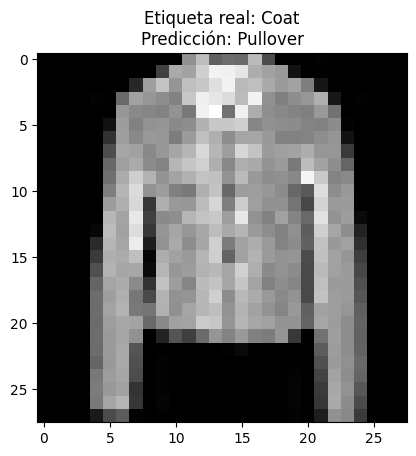

In [54]:
idx = np.where(test_labels==minority_class)[0][1]
plt.imshow(test_images[idx], cmap='gray')
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[predictions_aug[idx]]}")
plt.show()

### 1.3 - Balanceo mediante modificación de la función objetivo
- Modelo generado mediante un balanceo artificial de la clase "Coat"
- Se penaliza más el error para la clase que posee menos muestras, en este caso "Coat".
- De esta forma el modelo compensa ese desbalance.
- No cambia el dataset, sino cómo el modelo aprende.

In [55]:
class_counts = Counter(train_labels_ds)
total_samples = len(train_labels_ds)
n_classes = len(class_counts)

# Si hay menos muestras de una clase, mayor será su peso
class_weight = {i: total_samples / (n_classes * class_counts[i]) for i in class_counts}

# Mostramos los pesos asignados por clase
print("Pesos asignados por clase:")
for i in range(10):
    print(f"{class_names[i]}: {class_weight[i]:.3f}")

Pesos asignados por clase:
T-shirt/top: 0.902
Trouser: 0.902
Pullover: 0.902
Dress: 0.902
Coat: 54.100
Sandal: 0.902
Shirt: 0.902
Sneaker: 0.902
Bag: 0.902
Ankle boot: 0.902


In [56]:
# Fiteamos el modelo con class_weight
model_weighted = create_model()
history_weighted = model_weighted.fit(train_images_ds, train_labels_ds,
                                      epochs=10, batch_size=64, verbose=0,
                                      validation_split=0.2,
                                      class_weight=class_weight)

# Evaluamos el modelo con class_weight
y_pred_w = np.argmax(model_weighted.predict(test_images), axis=1)
report_w = classification_report(test_labels, y_pred_w, output_dict=True)

mask = test_labels == minority_class
acc_wgt = accuracy_score(test_labels[mask], y_pred_w[mask])
f1_wgt = f1_score(test_labels[mask], y_pred_w[mask], average='macro')

# Resultados
print("\n--- Métricas para clase 'Coat' (con class_weight) ---")
print(f"Accuracy (Coat): {acc_wgt:.4f}")
print(f"F1-score (Coat): {f1_wgt:.4f}")

c:\Users\Bruno\Desktop\INF395 - IRN\tareas\tarea_2\tf_venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- Métricas para clase 'Coat' (con class_weight) ---
Accuracy (Coat): 0.6920
F1-score (Coat): 0.1636


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


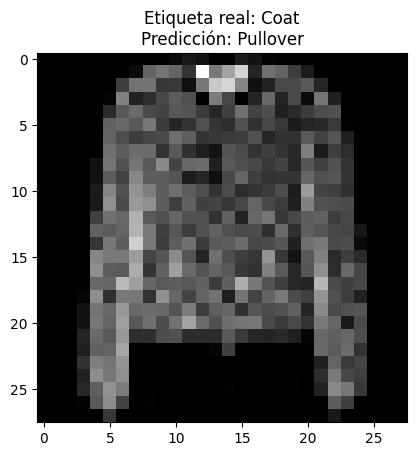

In [ ]:
idx = np.where(test_labels == minority_class)[0][2]

plt.imshow(test_images[idx], cmap='gray')
pred_label = np.argmax(model_weighted.predict(np.expand_dims(test_images[idx], 0)))
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[pred_label]}")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


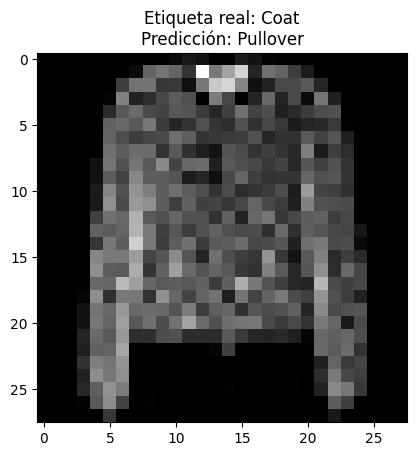

In [63]:
idx = np.where(test_labels == minority_class)[0][6]

plt.imshow(test_images[idx], cmap='gray')
pred_label = np.argmax(model_weighted.predict(np.expand_dims(test_images[idx], 0)))
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[pred_label]}")
plt.show()

### 1.4 - Modelo balanceado original
Dataset completo, sin crear recortes artificiales, éste se encuentra balanceado desde el inicio

In [58]:
model_bal = create_model()
model_bal.fit(train_images, train_labels, epochs=10, verbose=2)

prob_model_bal = tf.keras.Sequential([model_bal, tf.keras.layers.Softmax()])
predictions_bal = np.argmax(prob_model_bal.predict(test_images), axis=1)

acc_bal = accuracy_score(test_labels[mask], predictions_bal[mask])
f1_bal = f1_score(test_labels[mask], predictions_bal[mask], average='macro')
print(f"Balanceado original - Accuracy Coat: {acc_bal:.4f}, F1 Coat: {f1_bal:.4f}")



Epoch 1/10


c:\Users\Bruno\Desktop\INF395 - IRN\tareas\tarea_2\tf_venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 - 5s - 2ms/step - accuracy: 0.8256 - loss: 0.4986
Epoch 2/10
1875/1875 - 4s - 2ms/step - accuracy: 0.8626 - loss: 0.3761
Epoch 3/10
1875/1875 - 4s - 2ms/step - accuracy: 0.8771 - loss: 0.3366
Epoch 4/10
1875/1875 - 4s - 2ms/step - accuracy: 0.8858 - loss: 0.3116
Epoch 5/10
1875/1875 - 4s - 2ms/step - accuracy: 0.8922 - loss: 0.2939
Epoch 6/10
1875/1875 - 4s - 2ms/step - accuracy: 0.8957 - loss: 0.2792
Epoch 7/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9022 - loss: 0.2660
Epoch 8/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9035 - loss: 0.2574
Epoch 9/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9067 - loss: 0.2475
Epoch 10/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9111 - loss: 0.2385
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Balanceado original - Accuracy Coat: 0.8030, F1 Coat: 0.1485


Ejemplo de predicción con el Modelo Balanceado Original

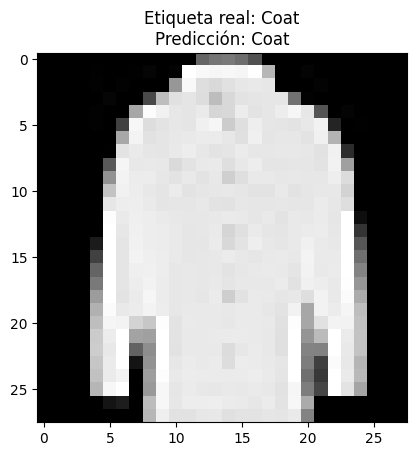

In [59]:
idx = np.where(test_labels==minority_class)[0][2]
plt.imshow(test_images[idx], cmap='gray')
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[predictions_bal[idx]]}")
plt.show()

### 1.5 - Comparación final de los 4 modelos

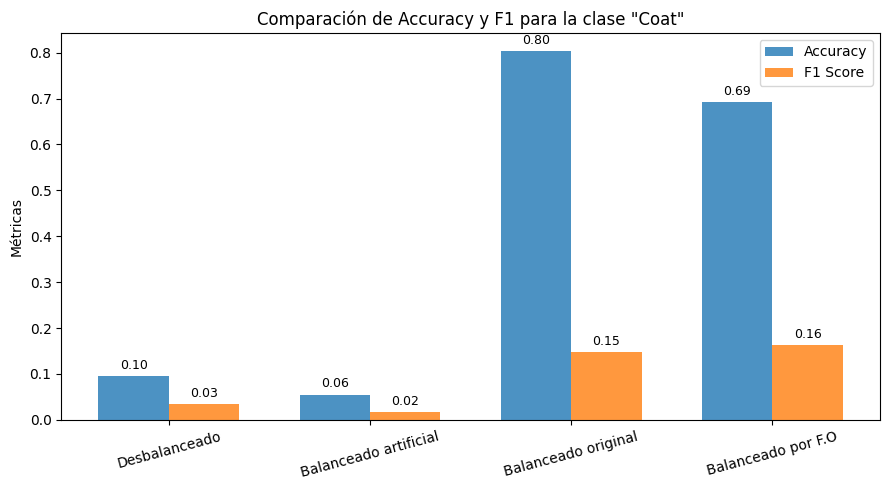

In [60]:
# Nombres de los modelos
models = [
    'Desbalanceado',
    'Balanceado artificial',
    'Balanceado original',
    'Balanceado por F.O'
]

# Métricas obtenidas (rellena con tus valores reales)
acc_values = [acc_ds, acc_aug, acc_bal, acc_wgt]
f1_values = [f1_ds, f1_aug, f1_bal, f1_wgt]

# Configuración de posiciones y ancho de barras
x = np.arange(len(models))
width = 0.35

# Crear figura
fig, ax = plt.subplots(figsize=(9,5))
rects1 = ax.bar(x - width/2, acc_values, width, label='Accuracy', alpha=0.8)
rects2 = ax.bar(x + width/2, f1_values, width, label='F1 Score', alpha=0.8)

# Etiquetas y título
ax.set_ylabel('Métricas')
ax.set_title('Comparación de Accuracy y F1 para la clase "Coat"')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.legend()

# Mostrar valores encima de cada barra
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=9)

plt.tight_layout()
plt.show()

# Parte II: Sistema de recomendación